In [2]:
import pandas 
%matplotlib inline 
import matplotlib.pyplot as plt 

from glob import glob 

In [3]:
def get_raw_data():
    for g in glob('uploads/*csv'):
        yield pandas.read_csv(g)
    
def get_dfs():
    for n, data in enumerate(get_raw_data()):
        data['batch'] = n 
        yield data 
        
dfs = get_dfs()
df = pandas.concat(dfs) 
df.shape

(12368, 9)

In [4]:
df['sample'].unique()

array(['WT', 'E164A', 'E123F', 'G456H', 'N220D', 'N163E', 'N163S', '142WT',
       'N287Q', 'N219Y', 'T221E', 'T344V', 'S237R', 'W317A', 'W119F',
       'Y117F', 'Q18A', 'Blank', 'GFP', 'Q19A', 'R240A', 'E164D', 'F415N',
       'Y166E', 'D322A', 'E406Q', 'F248K', 'F415D', 'F405A', 'H315Y',
       'blank', 'E353A', 'E177S', 'E353F', 'E426S', 'K413A', 'H378R',
       'L219A', 'W409Y', 'N293C', 'T15A', 'N220R', 'L362M', 'W325R',
       'N220Y', 'N220G', 'N404C', 'S16N', 'E164G', 'E164R', 'H178R',
       'R240E', 'N293D', 'W325G', 'H379T', 'W399R', 'adf', 'sf', 'A', 'B',
       'C', 'E406A', 'T296A', 'H315E', 'V320Q', 'WT-MT', 'N293T', 'Q284R',
       'H315D', 'S16T', 'C167F', 'E406N', 'Q19N', 'H119N', 'E177D',
       'H315A', 'H178N', 'M261E', 'GFP2', 'N239T', 'GFP1', 'WT2', 'WT1',
       'L272N', '139WT', 'Y312W', 'T378V', 'W147F', 'A259Y', 'Y145F',
       'T261E', 'Q17A', 'W351A', 'A278R', 'N310Q', 'H379R', 'E405A',
       'E388C', 'C167S', 'A227W', 'BLANK', 'E353E', 'Y166P', 'M221A',
 

In [5]:
df.columns

Index(['Unnamed: 0', 'well', 'rate', 's', 'sample', 'yield', 'dilution',
       'kobs', 'batch'],
      dtype='object')

In [6]:
from Bio import SeqIO 
from scipy.optimize import curve_fit 

In [7]:
def get_allowed():
    b = next(SeqIO.parse('/Users/alex/Documents/bagel-main/reference/sequence/bglb_model.fa', 'fasta'))
    alphabet = set(b.seq)
    print(len(alphabet))
    for n, res in enumerate(b.seq, 1):
        for letter in alphabet:
            yield '{}{}{}'.format(res, n, letter)
            
allowed = list(get_allowed())
len(allowed)

20


8980

In [8]:
def fit_mm(x, y):
    '''
    Attempt to fit x, y to MM eqn
    '''
    def mm_eqn(x, kcat, km): return x*kcat/(x+km)
    try:
        popt, pcov = curve_fit(mm_eqn, x, y, p0=(1e3, 0.1))
        if popt[0] < 0.01 or popt[0] > 20000:
            # check kcat between 0.01 and 20,000 turnover/min 
            popt = pcov = None, None 
        if popt[1] < 0.000001 or popt[1] > 1:
            # check KM is between 1 µM and 1 M   
            popt = pcov = None, None 
    except:
        popt = pcov = None, None 
    
    result = popt 
    return result 

In [9]:
exclude = [
    'G456H', 
    'E164A', 
    'E123F', 
    'WT'
]

In [10]:
cols = ('batch', 'mutant_name', 'kcat', 'km') 
dat = []

for idx, data in df.groupby(['batch', 'sample']):
    batch, mutant_name = idx 
    if mutant_name in allowed and mutant_name not in exclude:
#         print(len(data))
#         print(idx)
        result = fit_mm(data['s'], data['kobs']) 
#         print(result) 
#         break
        dat.append((batch, mutant_name, *result))

r = pandas.DataFrame(dat, columns=cols)
r

,batch,mutant_name,kcat,km
0,7,N163E,NaN,NaN
1,7,N163S,NaN,NaN
2,7,N220D,NaN,NaN
3,8,N163E,NaN,NaN
4,8,N163S,NaN,NaN
5,8,N220D,NaN,NaN
6,30,Q19A,10.852594,0.825381
7,30,R240A,2979.074074,0.022986
8,31,E164D,NaN,NaN
9,31,F415N,NaN,NaN


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x10f180b00>,
        <matplotlib.axes._subplots.AxesSubplot object at 0x114a8bcf8>]], dtype=object)

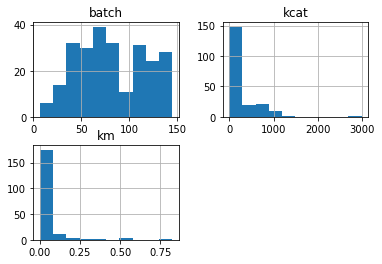

In [15]:
r.hist()

In [11]:
r.mutant_name.unique()

array(['N163E', 'N163S', 'N220D', 'Q19A', 'R240A', 'E164D', 'F415N',
       'Y166E', 'D322A', 'E406Q', 'F248K', 'F415D', 'F405A', 'H315Y',
       'E353A', 'E177S', 'E353F', 'E426S', 'K413A', 'L219A', 'N220R',
       'N293C', 'T15A', 'W409Y', 'L362M', 'N220G', 'N220Y', 'W325R',
       'E164G', 'E164R', 'N404C', 'S16N', 'H178R', 'N293D', 'R240E',
       'H379T', 'W325G', 'W399R', 'E406A', 'H315E', 'T296A', 'V320Q',
       'H315D', 'N293T', 'Q284R', 'C167F', 'E406N', 'S16T', 'E177D',
       'H119N', 'Q19N', 'H315A', 'H178N', 'M261E', 'L272N', 'H379R',
       'E388C', 'A227W', 'C167S', 'E353E', 'M221A', 'W325H', 'Y166P',
       'E222K', 'E222R', 'E222Y', 'H178A', 'I244N', 'N293A', 'N354A',
       'Y118F', 'Y295W', 'N293Q', 'W120F', 'N293S', 'Q313E', 'G153A',
       'L108N', 'N220S', 'W409E', 'T352V', 'H223E', 'W325A', 'E222A',
       'W325K', 'Y166F'], dtype=object)

In [12]:
therm = pandas.read_csv('/Users/alex/Documents/bglb_family/data_sets/thermal_targets.csv')
therm.mutant.unique()

array(['G12N', 'S14A', 'T15A', 'S16A', 'S16N', 'S17E', 'S17A', 'Y18A',
       'Q19S', 'Q19A', 'Q19C', 'Q19P', 'S32L', 'W34A', 'V52G', 'F72A',
       'R76A', 'I91E', 'H101R', 'H119A', 'H119N', 'H119E', 'W120H',
       'W120F', 'W120A', 'D121F', 'E154D', 'N163C', 'N163D', 'N163A',
       'N163E', 'N163K', 'E164A', 'E164G', 'E164R', 'Y166P', 'C167Q',
       'C167A', 'L171A', 'L171R', 'T175R', 'E177K', 'E177A', 'E177L',
       'H178A', 'H178R', 'A192S', 'T218A', 'N220A', 'N220R', 'N220H',
       'N220Y', 'N220G', 'M221A', 'E222H', 'E222A', 'E222Y', 'E222K',
       'E222R', 'E222Q', 'A236E', 'R240D', 'R240K', 'R240A', 'R240E',
       'I244N', 'I244E', 'A249E', 'M261D', 'N293C', 'N293A', 'N293D',
       'N293K', 'N293Q', 'Y294A', 'Y294F', 'Y294L', 'Y295A', 'Y295G',
       'T296A', 'T296E', 'S298E', 'I300N', 'Q313R', 'H315E', 'H315N',
       'M323A', 'M323K', 'W325H', 'W325C', 'W325R', 'W325A', 'W325L',
       'W325G', 'P329N', 'S331A', 'K341A', 'F343S', 'T352A', 'E353A',
       'N354A', 'G35

In [13]:
spec = pandas.read_csv('/Users/alex/Documents/bglb_family/data_sets/speculative_targets.csv')
spec_list = spec.mutant_name.unique()

/Users/alex/anaconda3/lib/python3.6/site-packages/matplotlib/figure.py:402: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "


Completely new mutant: Y166E
Completely new mutant: F248K
Completely new mutant: F415D
Completely new mutant: F405A
Completely new mutant: E353F
Completely new mutant: H315D
Completely new mutant: N293T
Completely new mutant: C167F


/Users/alex/anaconda3/lib/python3.6/site-packages/matplotlib/pyplot.py:524: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


Completely new mutant: E406N
Completely new mutant: S16T
Completely new mutant: E177D
Completely new mutant: Q19N
Completely new mutant: Y118F
Completely new mutant: Y295W
Completely new mutant: W409E
Completely new mutant: T352V
Completely new mutant: H223E
Completely new mutant: W325K
Completely new mutant: Y166F


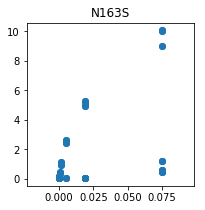

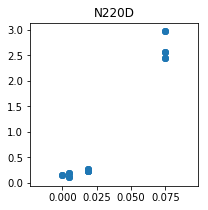

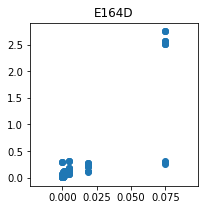

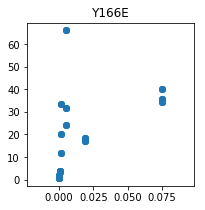

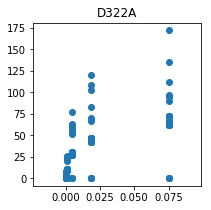

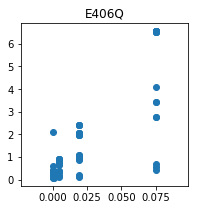

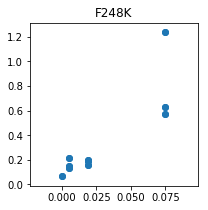

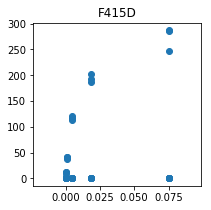

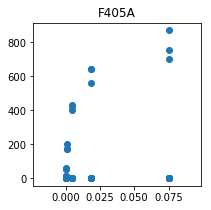

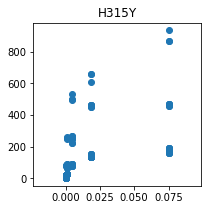

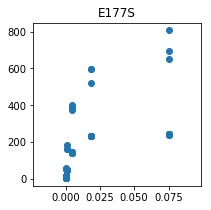

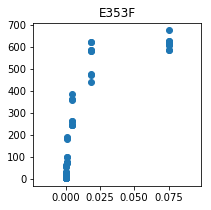

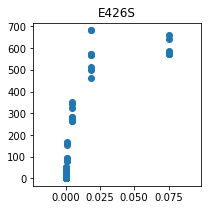

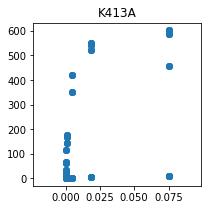

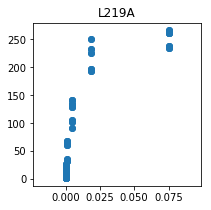

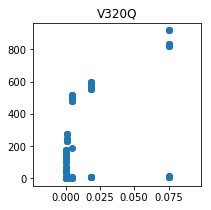

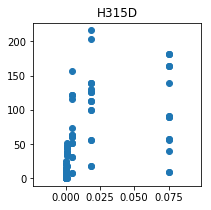

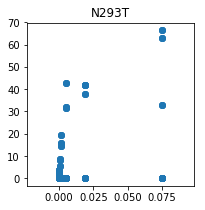

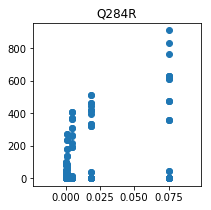

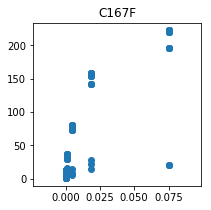

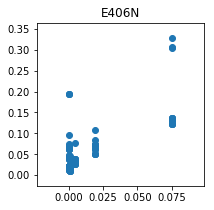

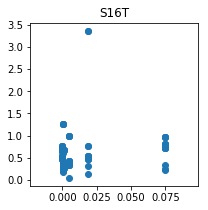

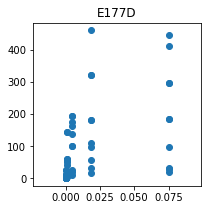

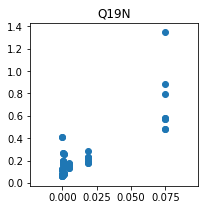

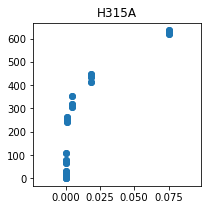

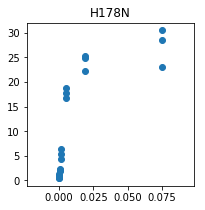

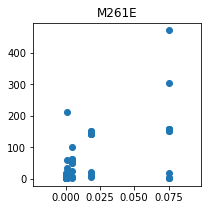

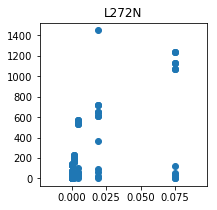

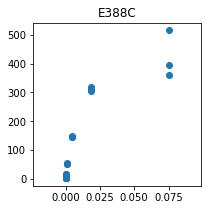

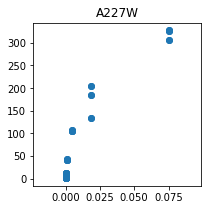

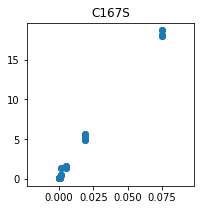

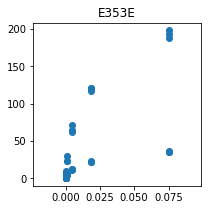

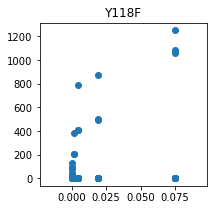

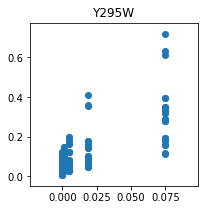

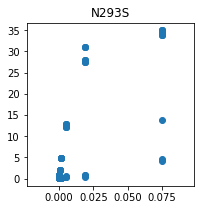

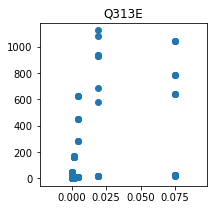

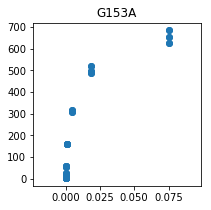

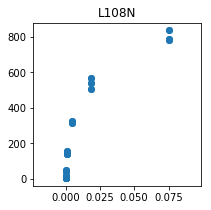

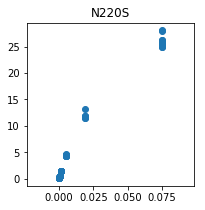

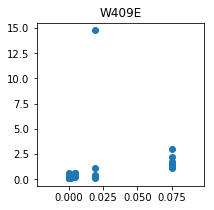

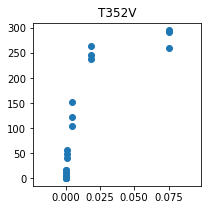

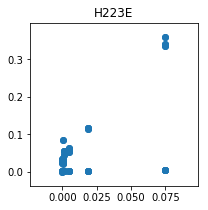

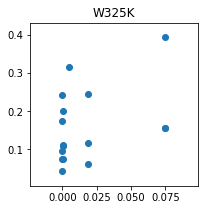

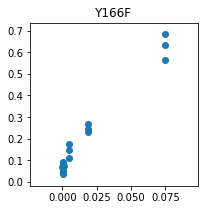

In [16]:
new_new = []
for new_mut in r.mutant_name.unique():
    if new_mut not in therm.mutant.unique():
        my_data = df[df['sample']==new_mut]
        fig, ax = plt.subplots(figsize=(3,3))
        ax.scatter(my_data['s'], my_data['kobs']) 
        ax.set(title=new_mut)
        fig.show()
        if new_mut not in spec_list:
            print("Completely new mutant: {}".format(new_mut))
            new_new.append(new_mut) 